In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

import torch
import torchvision.models as models
import numpy as np

import adverserial_noise.utils.utils as utils
from adverserial_noise.attacks.attack import AdversarialAttack, AttackType, BackendType

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model.to(device)

# No gradients needed for the network
model.eval()
for p in model.parameters():
    p.requires_grad = False

img_path = "panda.jpg"
img = utils.read_image(img_path)

In [3]:
img_tensor = utils.image_to_tensor(
    img, size=(224, 224), backend=BackendType.PYTORCH
).to(device)

target_class_index = torch.tensor([368], device=device)

In [4]:
adversarial_attack = AdversarialAttack()

adv_tensor, noise_tensor = adversarial_attack.run_attack(
    model=model,
    inputs=img_tensor,
    targets=target_class_index,
    attack_type=AttackType.FGSM,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="sum"),
)

Running fgsm attack with backend pytorch
epsilon: 0.02
loss_fn: CrossEntropyLoss()
verbose: False
tensor(16.3628, grad_fn=<NllLossBackward0>)


In [5]:
probs_orig = utils.get_pred_probs(model, img_tensor, backend=BackendType.PYTORCH)
probs_adv = utils.get_pred_probs(model, adv_tensor, backend=BackendType.PYTORCH)

pred_class_orig = np.argmax(probs_orig)
pred_class_adv = np.argmax(probs_adv)

class_names = utils.load_imagenet_classes()

In [6]:
print("predicted original class: ", class_names[pred_class_orig])
print("predicted adversarial class: ", class_names[pred_class_adv])

predicted original class:  giant panda
predicted adversarial class:  gibbon


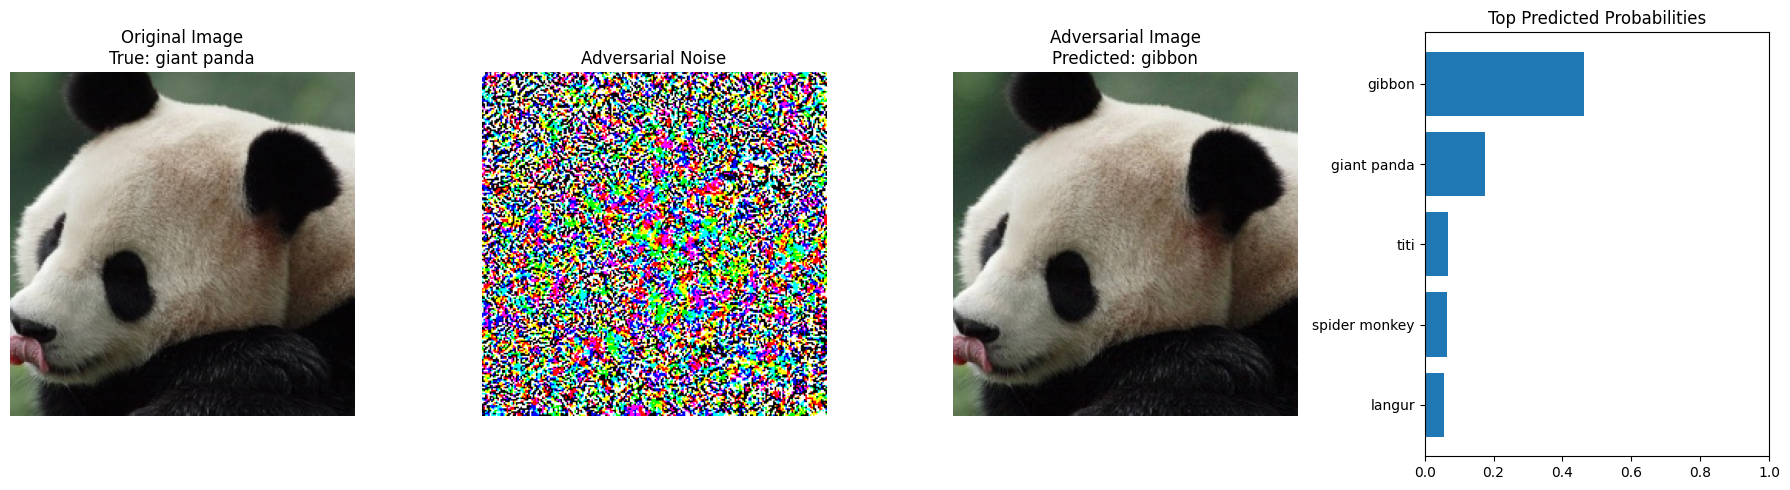

In [7]:
utils.visualize_attack(
    original=img_tensor,
    adversarial=adv_tensor,
    noise=noise_tensor,
    probs=probs_adv,
    predicted_class=class_names[pred_class_adv],
    true_class=class_names[pred_class_orig],
    class_names=class_names,
    backend=BackendType.PYTORCH,
)